In [1]:
!git clone https://github.com/Radja999/Anomaly_Detection_Pipeline.git


Cloning into 'Anomaly_Detection_Pipeline'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 42 (delta 5), reused 35 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 37.95 MiB | 20.93 MiB/s, done.
Resolving deltas: 100% (5/5), done.


**1) Setup and Inputs**

In [2]:
# ===============================
# Setup and Inputs
# ===============================
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# -------------------------------
# Repository directory structure
# -------------------------------
RAW_PUBLIC_DIR = "Anomaly_Detection_Pipeline/data/raw/CIC-IDS2017_CSVs"
RAW_PRIVATE_DIR = "Anomaly_Detection_Pipeline/data/raw/Lab_Generated_Benign_Dataset"
PROCESSED_DIR = "Anomaly_Detection_Pipeline/data/processed/"

PRIVATE_FILE = os.path.join(RAW_PRIVATE_DIR, "merged_flows.csv")
PUBLIC_BENIGN_FILE = os.path.join(PROCESSED_DIR, "public_benign_set.csv")
ATTACK_FILE = os.path.join(PROCESSED_DIR, "attack_set.csv")
PRIVATE_BENIGN_FILE = os.path.join(PROCESSED_DIR, "private_benign_set.csv")

pd.set_option("display.max_columns", 200)
print("Public CSV dir:", RAW_PUBLIC_DIR)
print("Private CSV   :", PRIVATE_FILE)
print("Outputs:")
print("  -", PUBLIC_BENIGN_FILE)
print("  -", ATTACK_FILE)
print("  -", PRIVATE_BENIGN_FILE)


Public CSV dir: Anomaly_Detection_Pipeline/data/raw/CIC-IDS2017_CSVs
Private CSV   : Anomaly_Detection_Pipeline/data/raw/Lab_Generated_Benign_Dataset/merged_flows.csv
Outputs:
  - Anomaly_Detection_Pipeline/data/processed/public_benign_set.csv
  - Anomaly_Detection_Pipeline/data/processed/attack_set.csv
  - Anomaly_Detection_Pipeline/data/processed/private_benign_set.csv


**2) Load and Merge Public CSVs**

In [3]:
# ===============================
# Load and Merge Public CSVs
# ===============================
csv_files = sorted(glob.glob(os.path.join(RAW_PUBLIC_DIR, "*.csv")))
print(f"Found {len(csv_files)} CSV files.")
if len(csv_files) == 0:
    raise FileNotFoundError("No CSV files found in RAW_PUBLIC_DIR.")

merged_df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)
print("Merged public shape:", merged_df.shape)

# Standardize columns
merged_df.columns = merged_df.columns.str.strip()


Found 8 CSV files.
Merged public shape: (2830743, 79)


**3) Resolve Header Duplicate and Basic Column Sanity**

In [4]:
# ===============================
# Resolve Header Duplicate and Sanity Checks
# ===============================
# If both 'Fwd Header Length' and 'Fwd Header Length.1' exist, inspect and drop the duplicate.
if "Fwd Header Length" in merged_df.columns and "Fwd Header Length.1" in merged_df.columns:
    corr_val = merged_df["Fwd Header Length"].corr(merged_df["Fwd Header Length.1"])
    print("Correlation between 'Fwd Header Length' and '.1':", corr_val)
    print(merged_df[["Fwd Header Length", "Fwd Header Length.1"]].describe())

    # Drop the duplicate '.1' column
    merged_df = merged_df.drop(columns=["Fwd Header Length.1"])
    print("Dropped 'Fwd Header Length.1'.")
else:
    print("No duplicate header column found.")

# Remove rows with negative 'Fwd Header Length'
if "Fwd Header Length" in merged_df.columns:
    neg_count = (merged_df["Fwd Header Length"] < 0).sum()
    print(f"Rows with negative 'Fwd Header Length': {neg_count}")
    if neg_count > 0:
        merged_df = merged_df[merged_df["Fwd Header Length"] >= 0].copy()
        print("Negative 'Fwd Header Length' rows removed.")
print("Shape after header fix and basic check:", merged_df.shape)


Correlation between 'Fwd Header Length' and '.1': 1.0
       Fwd Header Length  Fwd Header Length.1
count       2.830743e+06         2.830743e+06
mean       -2.599739e+04        -2.599739e+04
std         2.105286e+07         2.105286e+07
min        -3.221223e+10        -3.221223e+10
25%         4.000000e+01         4.000000e+01
50%         6.400000e+01         6.400000e+01
75%         1.200000e+02         1.200000e+02
max         4.644908e+06         4.644908e+06
Dropped 'Fwd Header Length.1'.
Rows with negative 'Fwd Header Length': 35
Negative 'Fwd Header Length' rows removed.
Shape after header fix and basic check: (2830708, 78)


**4) Remove Exact Duplicates**

In [5]:
# ===============================
# Remove Duplicates
# ===============================
dup_count = merged_df.duplicated().sum()
print("Duplicate rows:", dup_count)
if dup_count > 0:
    merged_df = merged_df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed.")
print("Shape after duplicate removal:", merged_df.shape)


Duplicate rows: 308381
Duplicates removed.
Shape after duplicate removal: (2522327, 78)


**5) Drop Constant Columns (Single-Value Features)**

In [ ]:
# ===============================
# Drop Constant Columns
# ===============================
constant_cols = [c for c in merged_df.columns if merged_df[c].nunique(dropna=False) == 1]
print(f"Constant columns found: {len(constant_cols)}")
if constant_cols:
    print(constant_cols)

# Drop them
if constant_cols:
    merged_df = merged_df.drop(columns=constant_cols)
    print("Dropped constant columns.")
print("Shape after dropping constants:", merged_df.shape)


Constant columns found: 8
['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Dropped constant columns.
Shape after dropping constants: (2522327, 70)


**6) Identify Mixed-Type and Categorical Columns (Report Only)**

In [6]:
# ===============================
# Mixed-Type and Categorical Columns (report only)
# ===============================
mixed_type_cols = []
for col in merged_df.columns:
    try:
        ntypes = merged_df[col].map(type).nunique()
        if ntypes > 1:
            mixed_type_cols.append(col)
    except Exception:
        pass

print(f"Mixed-type columns: {len(mixed_type_cols)}")
if mixed_type_cols:
    print(mixed_type_cols)

categorical_cols = merged_df.select_dtypes(include=["object"]).columns.tolist()
print(f"Categorical columns: {len(categorical_cols)}")
if categorical_cols:
    print(categorical_cols[:20], "...")


Mixed-type columns: 0
Categorical columns: 1
['Label'] ...


**7) Handle Missing/Infinite Values and Rate Columns**

In [7]:
# ===============================
# Handle Missing/Infinite Values and Rate Columns
# ===============================
df = merged_df.copy()

# Replace inf with NaN for unified handling
df = df.replace([np.inf, -np.inf], np.nan)

nan_cols = df.isna().sum()
nan_cols = nan_cols[nan_cols > 0].sort_values(ascending=False)
print("Columns with missing values (top 15):")
print(nan_cols.head(15))

# If rate columns exist, drop rows with NaN in those key columns
rate_cols = [c for c in ["Flow Bytes/s", "Flow Packets/s"] if c in df.columns]
if rate_cols:
    before = len(df)
    df = df.dropna(subset=rate_cols).reset_index(drop=True)
    print(f"Dropped {before - len(df)} rows due to NaN in rate columns {rate_cols}.")
else:
    print("Rate columns not found; skipping NaN drop on rate columns.")

print("Shape after NaN/inf handling:", df.shape)


Columns with missing values (top 15):
Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64
Dropped 1564 rows due to NaN in rate columns ['Flow Bytes/s', 'Flow Packets/s'].
Shape after NaN/inf handling: (2520763, 78)


**8) Inspect and Recalculate Suspicious Rate Features**

In [8]:
# ===============================
# Recalculate Suspicious Rate Features
# ===============================
# Recalculate Flow Packets/s from totals and duration (µs → seconds)
if all(c in df.columns for c in ["Total Fwd Packets", "Total Backward Packets", "Flow Duration"]):
    df["Flow Packets/s_recalc"] = (
        (df["Total Fwd Packets"] + df["Total Backward Packets"]) /
        (df["Flow Duration"] / 1e6)
    )
    df.loc[df["Flow Duration"] <= 0, "Flow Packets/s_recalc"] = np.nan

# Recalculate Flow Bytes/s from total bytes and duration (µs → ms)
if all(c in df.columns for c in ["Total Length of Fwd Packets", "Total Length of Bwd Packets", "Flow Duration"]):
    df["Flow Bytes/s_recalc"] = (
        (df["Total Length of Fwd Packets"] + df["Total Length of Bwd Packets"]) /
        (df["Flow Duration"] / 1000.0)
    )

# Compare original vs recalculated when present
for base, recalc in [("Flow Packets/s", "Flow Packets/s_recalc"),
                     ("Flow Bytes/s", "Flow Bytes/s_recalc")]:
    if base in df.columns and recalc in df.columns:
        comp = df[[base, recalc]].dropna()
        if not comp.empty:
            corr = comp.corr().iloc[0,1]
            mean_abs_diff = (comp[base] - comp[recalc]).abs().mean()
            print(f"{base} vs {recalc} | corr={corr:.4f} | mean_abs_diff={mean_abs_diff:.6f}")
        else:
            print(f"{base} vs {recalc}: insufficient non-NaN rows to compare.")


Flow Packets/s vs Flow Packets/s_recalc | corr=1.0000 | mean_abs_diff=0.000001
Flow Bytes/s vs Flow Bytes/s_recalc | corr=1.0000 | mean_abs_diff=1410195.632734


**9) Correct Negative Values by Feature Group**

In [9]:
# ===============================
# Correct Negative Values by Feature Group
# ===============================
time_features = [c for c in ["Flow Duration", "Flow IAT Mean", "Flow IAT Max", "Flow IAT Min"] if c in df.columns]
rate_features = [c for c in ["Flow Bytes/s", "Flow Packets/s"] if c in df.columns]
window_features = [c for c in ["Init_Win_bytes_forward", "Init_Win_bytes_backward", "min_seg_size_forward"] if c in df.columns]

corrected_features = time_features + rate_features + window_features

df_before = df[corrected_features].copy() if corrected_features else None

# Time and rate features: absolute value
for c in time_features + rate_features:
    df[c] = df[c].abs()

# Window features: replace negatives with median of non-negative entries
for c in window_features:
    median_val = df.loc[df[c] >= 0, c].median() if (df[c] >= 0).any() else 0.0
    df.loc[df[c] < 0, c] = median_val

# Check remaining negatives
neg_counts = (df[corrected_features] < 0).sum() if corrected_features else pd.Series(dtype=int)
print("Remaining negatives by column:\n", neg_counts[neg_counts > 0] if not neg_counts.empty else "None")

# Drop recalculated helpers if they exist (keep originals)
recalc_cols = [c for c in df.columns if c.endswith("_recalc")]
if recalc_cols:
    df = df.drop(columns=recalc_cols)
    print("Dropped recalculated helper columns:", recalc_cols)

print("Shape after corrections:", df.shape)


Remaining negatives by column:
 Series([], dtype: int64)
Dropped recalculated helper columns: ['Flow Packets/s_recalc', 'Flow Bytes/s_recalc']
Shape after corrections: (2520763, 78)


**10) Split into Public Benign and Attack, Save Outputs**

In [12]:
# ===============================
# Split into Public Benign and Attack
# ===============================
label_cols = [c for c in df.columns if "label" in c.lower()]
if not label_cols:
    raise ValueError("No label column found in public dataset after cleaning.")
label_col = label_cols[0]
print("Detected label column:", label_col)

# Split by label
public_benign_df = df[df[label_col].astype(str).str.contains("BENIGN", case=False, na=False)].copy()
attack_df = df[~df[label_col].astype(str).str.contains("BENIGN", case=False, na=False)].copy()

# Drop label from both outputs
public_benign_df = public_benign_df.drop(columns=[label_col])
attack_df = attack_df.drop(columns=[label_col])

print("Public shape after cleaning (pre-split):", df.shape)
print("Public benign shape:", public_benign_df.shape)
print("Attack shape:", attack_df.shape)

# Persist the set of columns we ended with for alignment later
public_columns_after_clean = public_benign_df.columns.tolist()

# Save outputs
public_benign_df.to_csv(PUBLIC_BENIGN_FILE, index=False)
attack_df.to_csv(ATTACK_FILE, index=False)
print("Saved:", PUBLIC_BENIGN_FILE)
print("Saved:", ATTACK_FILE)


Detected label column: Label
Public shape after cleaning (pre-split): (2520763, 78)
Public benign shape: (2095022, 77)
Attack shape: (425741, 77)
Saved: Anomaly_Detection_Pipeline/data/processed/public_benign_set.csv
Saved: Anomaly_Detection_Pipeline/data/processed/attack_set.csv


**11) Load and Clean Private Benign Dataset, Align to Public Schema, Save**

In [15]:
# ===============================
# Load and Clean Private Benign Dataset, Align to Public Schema
# ===============================
dfp = pd.read_csv(PRIVATE_FILE)
print("Private raw shape:", dfp.shape)

# Column mapping to align private names with public schema
rename_mapping = {
    "dst_port": "Destination Port",
    "flow_duration": "Flow Duration",
    "flow_byts_s": "Flow Bytes/s",
    "flow_pkts_s": "Flow Packets/s",
    "fwd_pkts_s": "Fwd Packets/s",
    "bwd_pkts_s": "Bwd Packets/s",
    "tot_fwd_pkts": "Total Fwd Packets",
    "tot_bwd_pkts": "Total Backward Packets",
    "totlen_fwd_pkts": "Total Length of Fwd Packets",
    "totlen_bwd_pkts": "Total Length of Bwd Packets",
    "fwd_pkt_len_max": "Fwd Packet Length Max",
    "fwd_pkt_len_min": "Fwd Packet Length Min",
    "fwd_pkt_len_mean": "Fwd Packet Length Mean",
    "fwd_pkt_len_std": "Fwd Packet Length Std",
    "bwd_pkt_len_max": "Bwd Packet Length Max",
    "bwd_pkt_len_min": "Bwd Packet Length Min",
    "bwd_pkt_len_mean": "Bwd Packet Length Mean",
    "bwd_pkt_len_std": "Bwd Packet Length Std",
    "pkt_len_max": "Max Packet Length",
    "pkt_len_min": "Min Packet Length",
    "pkt_len_mean": "Packet Length Mean",
    "pkt_len_std": "Packet Length Std",
    "pkt_len_var": "Packet Length Variance",
    "fwd_header_len": "Fwd Header Length",
    "bwd_header_len": "Bwd Header Length",
    "fwd_seg_size_min": "min_seg_size_forward",
    "fwd_act_data_pkts": "act_data_pkt_fwd",
    "flow_iat_mean": "Flow IAT Mean",
    "flow_iat_max": "Flow IAT Max",
    "flow_iat_min": "Flow IAT Min",
    "flow_iat_std": "Flow IAT Std",
    "fwd_iat_tot": "Fwd IAT Total",
    "fwd_iat_max": "Fwd IAT Max",
    "fwd_iat_min": "Fwd IAT Min",
    "fwd_iat_mean": "Fwd IAT Mean",
    "fwd_iat_std": "Fwd IAT Std",
    "bwd_iat_tot": "Bwd IAT Total",
    "bwd_iat_max": "Bwd IAT Max",
    "bwd_iat_min": "Bwd IAT Min",
    "bwd_iat_mean": "Bwd IAT Mean",
    "bwd_iat_std": "Bwd IAT Std",
    "fwd_psh_flags": "Fwd PSH Flags",
    "bwd_psh_flags": "Bwd PSH Flags",
    "fwd_urg_flags": "Fwd URG Flags",
    "bwd_urg_flags": "Bwd URG Flags",
    "fin_flag_cnt": "FIN Flag Count",
    "syn_flag_cnt": "SYN Flag Count",
    "rst_flag_cnt": "RST Flag Count",
    "psh_flag_cnt": "PSH Flag Count",
    "ack_flag_cnt": "ACK Flag Count",
    "urg_flag_cnt": "URG Flag Count",
    "ece_flag_cnt": "ECE Flag Count",
    "down_up_ratio": "Down/Up Ratio",
    "pkt_size_avg": "Average Packet Size",
    "init_fwd_win_byts": "Init_Win_bytes_forward",
    "init_bwd_win_byts": "Init_Win_bytes_backward",
    "active_max": "Active Max",
    "active_min": "Active Min",
    "active_mean": "Active Mean",
    "active_std": "Active Std",
    "idle_max": "Idle Max",
    "idle_min": "Idle Min",
    "idle_mean": "Idle Mean",
    "idle_std": "Idle Std",
    "fwd_byts_b_avg": "Fwd Avg Bytes/Bulk",
    "fwd_pkts_b_avg": "Fwd Avg Packets/Bulk",
    "bwd_byts_b_avg": "Bwd Avg Bytes/Bulk",
    "bwd_pkts_b_avg": "Bwd Avg Packets/Bulk",
    "fwd_blk_rate_avg": "Fwd Avg Bulk Rate",
    "bwd_blk_rate_avg": "Bwd Avg Bulk Rate",
    "fwd_seg_size_avg": "Avg Fwd Segment Size",
    "bwd_seg_size_avg": "Avg Bwd Segment Size",
    "cwr_flag_count": "CWE Flag Count",
    "subflow_fwd_pkts": "Subflow Fwd Packets",
    "subflow_bwd_pkts": "Subflow Bwd Packets",
    "subflow_fwd_byts": "Subflow Fwd Bytes",
    "subflow_bwd_byts": "Subflow Bwd Bytes"
}

dfp = dfp.rename(columns=rename_mapping)
dfp.columns = dfp.columns.str.strip()

# Drop unneeded raw columns if present
dfp.drop(columns=["src_ip", "dst_ip", "protocol", "timestamp", "src_port"], inplace=True, errors="ignore")

# Remove duplicates
dup_p = dfp.duplicated().sum()
if dup_p > 0:
    dfp = dfp.drop_duplicates().reset_index(drop=True)

# Align columns to the cleaned public benign schema:
# 1) keep only columns that exist in the public benign set
# 2) add any missing public benign columns, filled with 0.0
target_cols = public_columns_after_clean
dfp = dfp.reindex(columns=target_cols, fill_value=0.0)

print("Private benign shape after cleaning:", dfp.shape)
dfp.to_csv(PRIVATE_BENIGN_FILE, index=False)
print("Saved:", PRIVATE_BENIGN_FILE)


Private raw shape: (17898, 82)
Private benign shape after cleaning: (15842, 77)
Saved: Anomaly_Detection_Pipeline/data/processed/private_benign_set.csv


**12) Analysis (Public Benign Only)**

Loaded public benign: (2095022, 77)
Number of unique destination ports: 53788
Top 15 most common ports:
Destination Port
53      876780
443     470173
80      217956
123      21312
22        6868
389       5826
88        5062
21        3441
137       2936
465       2786
3268      2357
139       2287
445       1911
0         1561
8080      1332
Name: count, dtype: int64


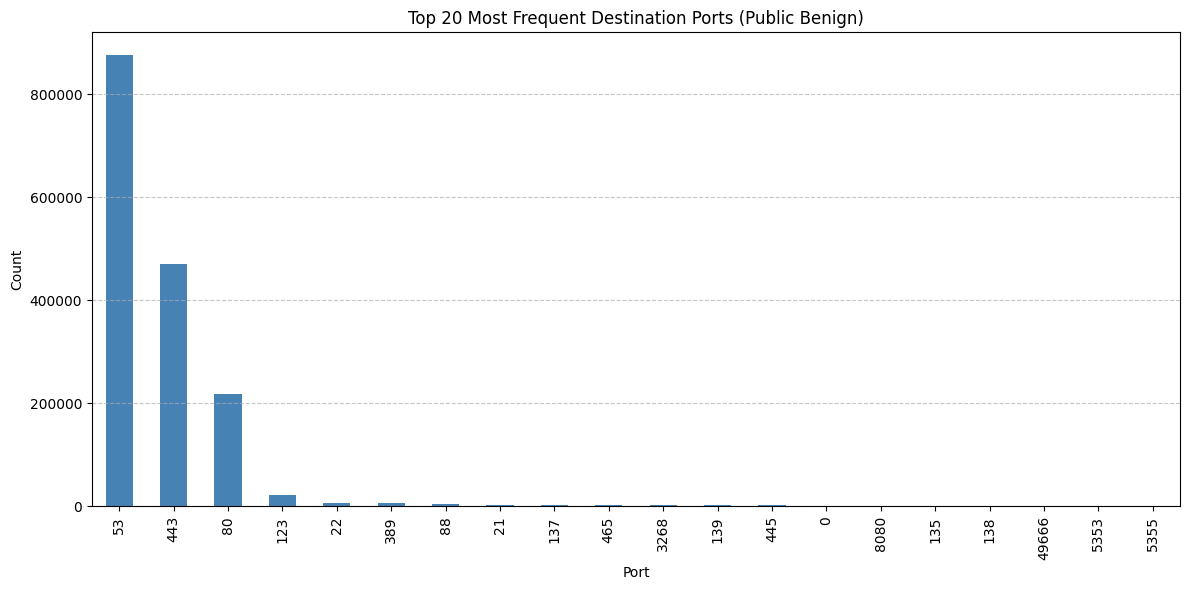

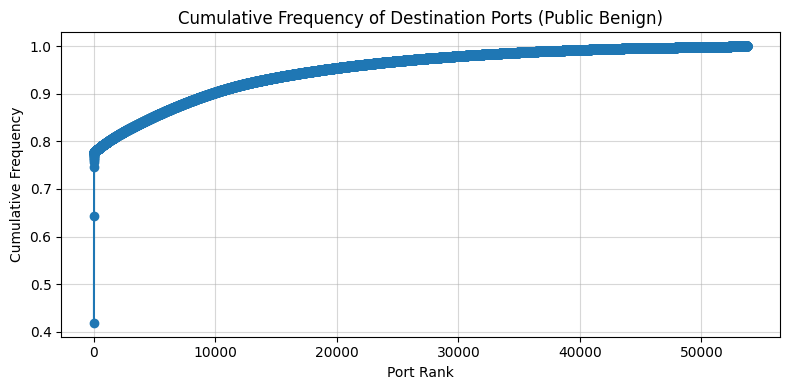

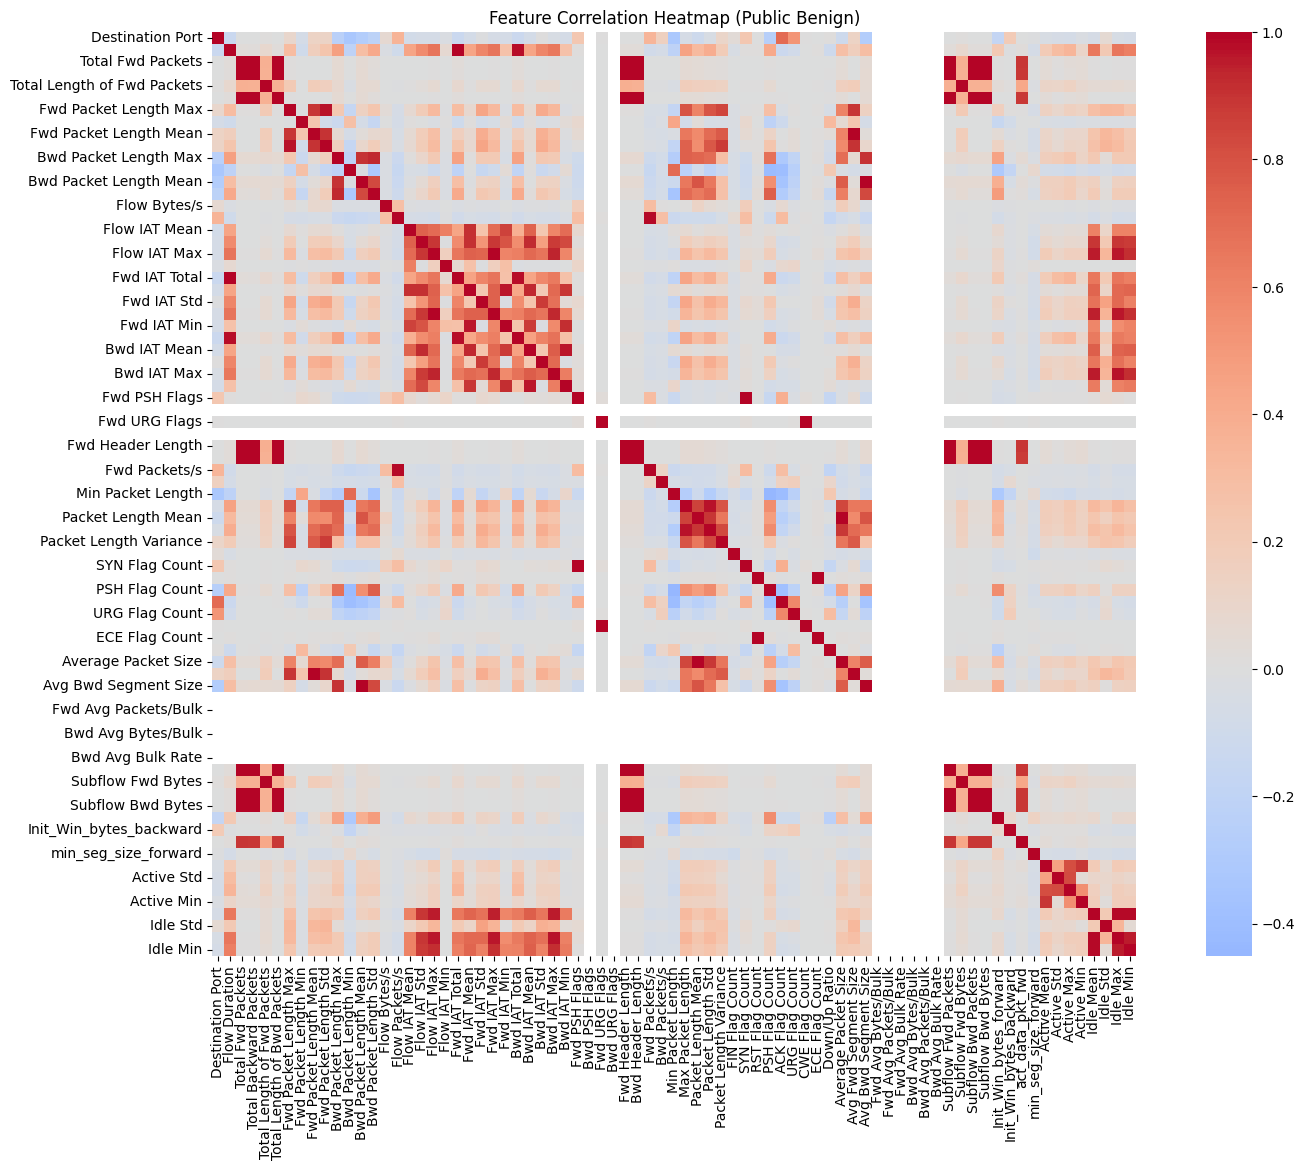

Strongly correlated pairs (|r| ≥ 0.8): 101


,Feature1,Feature2,Correlation
4170,Avg Bwd Segment Size,Bwd Packet Length Mean,1.000000
3805,CWE Flag Count,Fwd URG Flags,1.000000
4089,Avg Fwd Segment Size,Fwd Packet Length Mean,1.000000
2354,Fwd PSH Flags,SYN Flag Count,1.000000
4854,Subflow Bwd Packets,Total Backward Packets,1.000000
4699,Subflow Fwd Packets,Total Fwd Packets,1.000000
4933,Subflow Bwd Bytes,Total Length of Bwd Packets,1.000000
4778,Subflow Fwd Bytes,Total Length of Fwd Packets,0.999999
2698,Bwd Header Length,Total Backward Packets,0.999565
2758,Bwd Header Length,Subflow Bwd Packets,0.999565


In [17]:
# ===============================
# Analysis: Public Benign Only
# ===============================
pb = pd.read_csv(PUBLIC_BENIGN_FILE)
print("Loaded public benign:", pb.shape)

# --- Port distribution ---
if "Destination Port" in pb.columns:
    unique_ports = pb["Destination Port"].nunique()
    print("Number of unique destination ports:", unique_ports)
    print("Top 15 most common ports:")
    print(pb["Destination Port"].value_counts().head(15))

    plt.figure(figsize=(12, 6))
    pb["Destination Port"].value_counts().head(20).plot(kind="bar", color="steelblue")
    plt.title("Top 20 Most Frequent Destination Ports (Public Benign)")
    plt.xlabel("Port")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    port_freq = pb["Destination Port"].value_counts(normalize=True).cumsum()
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(port_freq)), port_freq.values, marker="o")
    plt.title("Cumulative Frequency of Destination Ports (Public Benign)")
    plt.xlabel("Port Rank")
    plt.ylabel("Cumulative Frequency")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Correlation heatmap ---
plt.figure(figsize=(18, 12))
corr = pb.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar=True)
plt.title("Feature Correlation Heatmap (Public Benign)")
plt.show()

# --- Strong correlations ---
corr_matrix = pb.corr(numeric_only=True)
threshold = 0.8
pairs = (
    corr_matrix.unstack()
    .reset_index()
    .rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"})
)
pairs = pairs[pairs["Feature1"] < pairs["Feature2"]]
pairs = pairs[np.abs(pairs["Correlation"]) >= threshold].sort_values("Correlation", ascending=False)
print(f"Strongly correlated pairs (|r| ≥ {threshold}): {len(pairs)}")
display(pairs.head(30))


Top 20 most variant features:


,0
Flow Duration,9.724061e+14
Fwd IAT Total,9.645476e+14
Bwd IAT Total,9.137481e+14
Flow Bytes/s,8.460123e+14
Fwd IAT Max,2.284234e+14
Flow IAT Max,2.256089e+14
Idle Max,2.145187e+14
Bwd IAT Max,2.047657e+14
Idle Mean,1.961049e+14
Idle Min,1.878075e+14


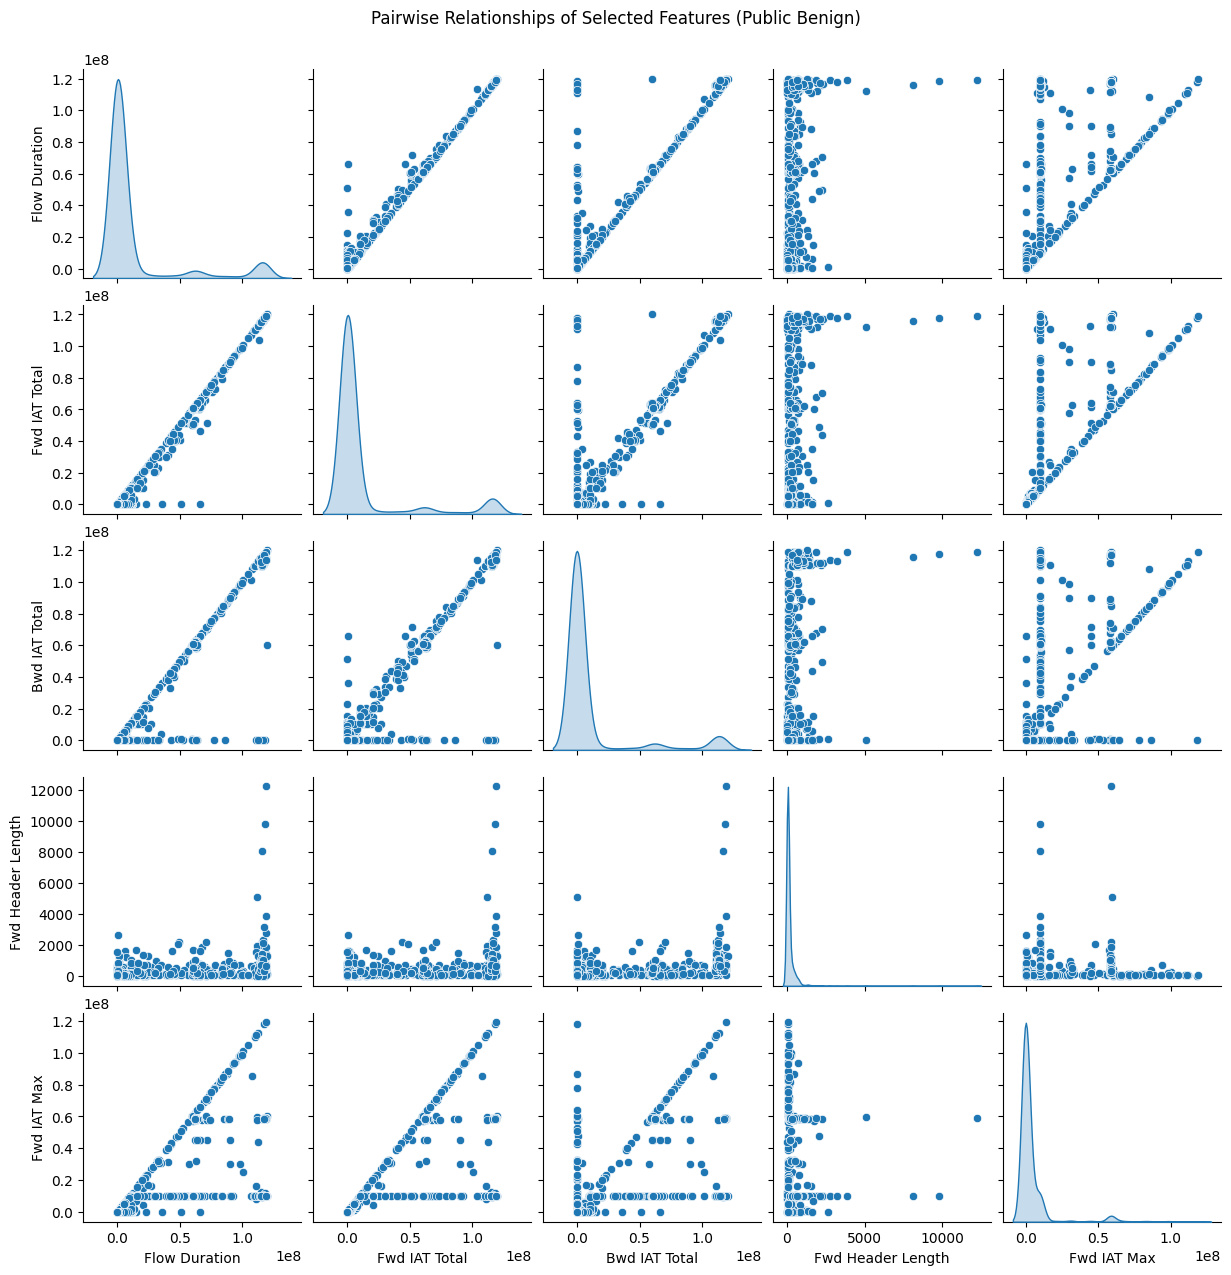

In [18]:
# --- Variance ranking and pairplot ---
num_cols = pb.select_dtypes(include=[np.number]).columns
variances = pb[num_cols].var().sort_values(ascending=False)
print("Top 20 most variant features:")
display(variances.head(20))

# Pairplot on a small set of representative features if present
subset_cols = [c for c in ["Flow Duration", "Fwd IAT Total", "Bwd IAT Total", "Fwd Header Length", "Fwd IAT Max"] if c in pb.columns]
if len(subset_cols) >= 2:
    sns.pairplot(pb[subset_cols].sample(min(3000, len(pb)), random_state=42), diag_kind="kde")
    plt.suptitle("Pairwise Relationships of Selected Features (Public Benign)", y=1.02)
    plt.show()


Top outlier-heavy features (Public Benign):


,Feature,Outlier Count,Outlier %,Min,Median,Max
58,Init_Win_bytes_backward,787950,37.610584,0.0,235.000000,6.553500e+04
13,Bwd Packet Length Std,505896,24.147527,0.0,0.000000,4.113240e+03
17,Flow IAT Std,494302,23.594120,0.0,223.445743,8.480026e+07
9,Fwd Packet Length Std,493758,23.568153,0.0,0.000000,7.125597e+03
1,Flow Duration,486523,23.222811,1.0,39968.500000,1.200000e+08
23,Fwd IAT Max,484919,23.146249,0.0,4.000000,1.200000e+08
18,Flow IAT Max,483107,23.059758,1.0,31594.000000,1.200000e+08
35,Bwd Packets/s,481224,22.969878,0.0,25.047834,2.000000e+06
20,Fwd IAT Total,479637,22.894127,0.0,4.000000,1.200000e+08
21,Fwd IAT Mean,474384,22.643390,0.0,4.000000,1.200000e+08


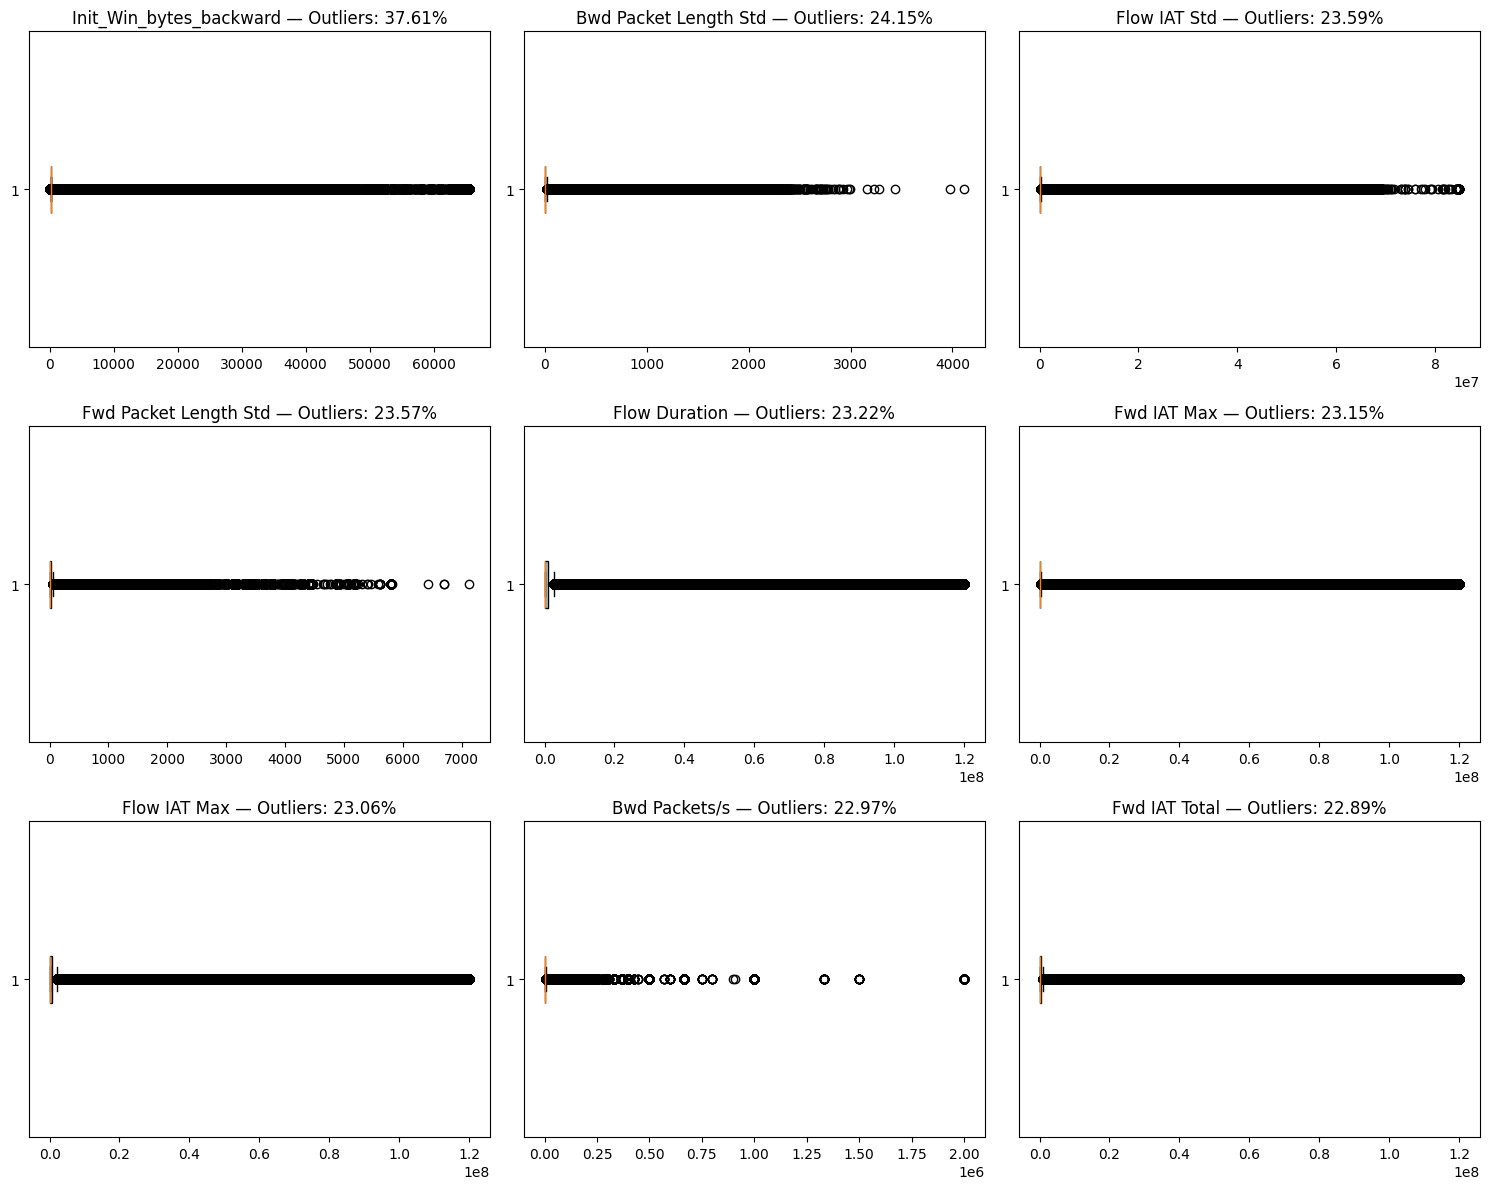

In [ ]:
# --- Outlier summary via IQR rule ---
def get_outlier_summary(df):
    summary = []
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        summary.append({
            "Feature": col,
            "Outlier Count": int(outliers),
            "Outlier %": 100.0 * outliers / len(df),
            "Min": df[col].min(),
            "Median": df[col].median(),
            "Max": df[col].max()
        })
    return pd.DataFrame(summary).sort_values("Outlier %", ascending=False)

outlier_summary = get_outlier_summary(pb)
print("Top outlier-heavy features (Public Benign):")
display(outlier_summary.head(20))

# Boxplots for the top 9 outlier-heavy features
top_feats = outlier_summary.head(9)["Feature"].tolist()
plt.figure(figsize=(15, 12))
for i, col in enumerate(top_feats, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(pb[col].values, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    plt.title(f"{col} — Outliers: {outlier_summary.set_index('Feature').loc[col, 'Outlier %']:.2f}%")
plt.tight_layout()
plt.show()


In [ ]:
# --- Skewness and kurtosis ---
from scipy.stats import skew, kurtosis

num_cols = pb.select_dtypes(include=[np.number]).columns
skew_vals = pb[num_cols].apply(lambda x: skew(x.dropna()))
kurt_vals = pb[num_cols].apply(lambda x: kurtosis(x.dropna()))

sk_df = pd.DataFrame({"Feature": num_cols, "Skewness": skew_vals, "Kurtosis": kurt_vals}).sort_values("Skewness", ascending=False)
display(sk_df.head(30))

n_strong = (sk_df["Skewness"].abs() > 1.0).sum()
print(f"Strongly skewed features (|skew| > 1.0): {n_strong} / {len(sk_df)}")


,Feature,Skewness,Kurtosis
Total Length of Fwd Packets,Total Length of Fwd Packets,780.848387,881483.805703
Subflow Fwd Bytes,Subflow Fwd Bytes,779.131483,878651.719257
act_data_pkt_fwd,act_data_pkt_fwd,244.867298,61495.249670
Total Backward Packets,Total Backward Packets,210.511582,45903.388768
Subflow Bwd Packets,Subflow Bwd Packets,210.511582,45903.388768
Total Fwd Packets,Total Fwd Packets,210.274658,45714.282317
Subflow Fwd Packets,Subflow Fwd Packets,210.274658,45714.282317
Subflow Bwd Bytes,Subflow Bwd Bytes,210.210827,45595.756452
Total Length of Bwd Packets,Total Length of Bwd Packets,210.207035,45593.867554
Fwd Header Length,Fwd Header Length,209.551980,45564.664438


Strongly skewed features (|skew| > 1.0): 67 / 69


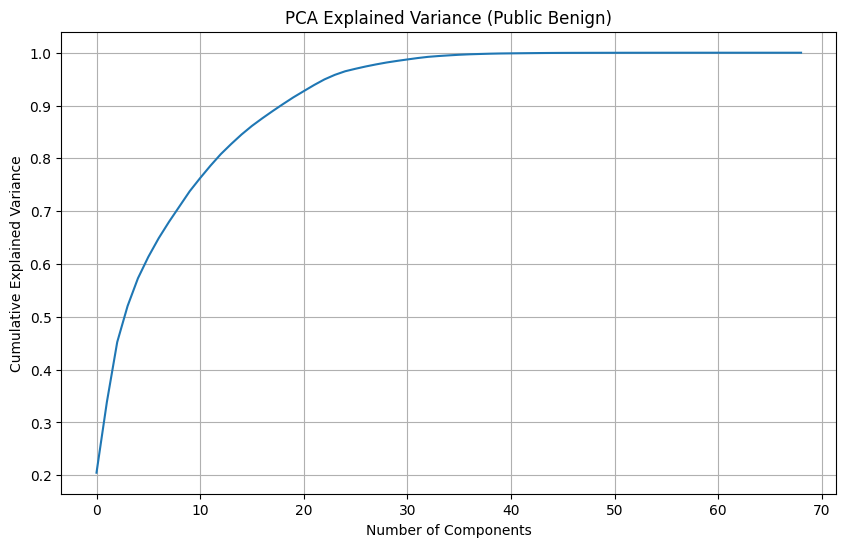

In [ ]:
# --- PCA variance analysis ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

num_df = pb.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

pca = PCA()
pca.fit(X_scaled)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance (Public Benign)")
plt.grid()
plt.show()


In [ ]:
!pip freeze > requirements_colab.txt